In [1]:
import math
import random
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
import seaborn as sns

In [2]:
from sklearn import preprocessing
from scipy.signal import find_peaks
import statsmodels.api as sma
import sklearn.metrics as sm

#### signal_resample

In [3]:
import scipy.ndimage
import scipy.signal

def signal_resample(
    signal, desired_length=None, sampling_rate=None, desired_sampling_rate=None, method="interpolation"
):
    """Resample a continuous signal to a different length or sampling rate.
    Up- or down-sample a signal. The user can specify either a desired length for the vector, or input
    the original sampling rate and the desired sampling rate.
    See https://github.com/neuropsychology/NeuroKit/scripts/resampling.ipynb for a comparison of the methods.
    Parameters
    ----------
    signal :  Union[list, np.array, pd.Series]
        The signal (i.e., a time series) in the form of a vector of values.
    desired_length : int
        The desired length of the signal.
    sampling_rate : int
        The original sampling frequency (in Hz, i.e., samples/second).
    desired_sampling_rate : int
        The desired (output) sampling frequency (in Hz, i.e., samples/second).
    method : str
        Can be 'interpolation' (see `scipy.ndimage.zoom()`), 'numpy' for numpy's interpolation
        (see `numpy.interp()`),'pandas' for Pandas' time series resampling, 'poly' (see `scipy.signal.resample_poly()`)
        or 'FFT' (see `scipy.signal.resample()`) for the Fourier method. FFT is the most accurate
        (if the signal is periodic), but becomes exponentially slower as the signal length increases.
        In contrast, 'interpolation' is the fastest, followed by 'numpy', 'poly' and 'pandas'.
    Returns
    -------
    array
        Vector containing resampled signal values.
    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> import neurokit2 as nk
    >>>
    >>> signal = np.cos(np.linspace(start=0, stop=20, num=100))
    >>>
    >>> # Downsample
    >>> downsampled_interpolation = nk.signal_resample(signal, method="interpolation",
    ...                                                sampling_rate=1000, desired_sampling_rate=500)
    >>> downsampled_fft = nk.signal_resample(signal, method="FFT",
    ...                                      sampling_rate=1000, desired_sampling_rate=500)
    >>> downsampled_poly = nk.signal_resample(signal, method="poly",
    ...                                       sampling_rate=1000, desired_sampling_rate=500)
    >>> downsampled_numpy = nk.signal_resample(signal, method="numpy",
    ...                                        sampling_rate=1000, desired_sampling_rate=500)
    >>> downsampled_pandas = nk.signal_resample(signal, method="pandas",
    ...                                         sampling_rate=1000, desired_sampling_rate=500)
    >>>
    >>> # Upsample
    >>> upsampled_interpolation = nk.signal_resample(downsampled_interpolation,
    ...                                              method="interpolation",
    ...                                              sampling_rate=500, desired_sampling_rate=1000)
    >>> upsampled_fft = nk.signal_resample(downsampled_fft, method="FFT",
    ...                                    sampling_rate=500, desired_sampling_rate=1000)
    >>> upsampled_poly = nk.signal_resample(downsampled_poly, method="poly",
    ...                                     sampling_rate=500, desired_sampling_rate=1000)
    >>> upsampled_numpy = nk.signal_resample(downsampled_numpy, method="numpy",
    ...                                      sampling_rate=500, desired_sampling_rate=1000)
    >>> upsampled_pandas = nk.signal_resample(downsampled_pandas, method="pandas",
    ...                                       sampling_rate=500, desired_sampling_rate=1000)
    >>>
    >>> # Compare with original
    >>> fig = pd.DataFrame({"Original": signal,
    ...                     "Interpolation": upsampled_interpolation,
    ...                     "FFT": upsampled_fft,
    ...                     "Poly": upsampled_poly,
    ...                     "Numpy": upsampled_numpy,
    ...                     "Pandas": upsampled_pandas}).plot(style='.-')
    >>> fig #doctest: +SKIP
    >>>
    >>> # Timing benchmarks
    >>> %timeit nk.signal_resample(signal, method="interpolation",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    >>> %timeit nk.signal_resample(signal, method="FFT",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    >>> %timeit nk.signal_resample(signal, method="poly",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    >>> %timeit nk.signal_resample(signal, method="numpy",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    >>> %timeit nk.signal_resample(signal, method="pandas",
    ...                            sampling_rate=1000, desired_sampling_rate=500) #doctest: +SKIP
    See Also
    --------
    scipy.signal.resample_poly, scipy.signal.resample, scipy.ndimage.zoom
    """
    if desired_length is None:
        desired_length = int(np.round(len(signal) * desired_sampling_rate / sampling_rate))

    # Sanity checks
    if len(signal) == desired_length:
        return signal

    # Resample
    if method.lower() == "fft":
        resampled = _resample_fft(signal, desired_length)
    elif method.lower() == "poly":
        resampled = _resample_poly(signal, desired_length)
    elif method.lower() == "numpy":
        resampled = _resample_numpy(signal, desired_length)
    elif method.lower() == "pandas":
        resampled = _resample_pandas(signal, desired_length)
    else:
        resampled = _resample_interpolation(signal, desired_length)

    return resampled


# =============================================================================
# Methods
# =============================================================================
def _resample_numpy(signal, desired_length):
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, desired_length, endpoint=False),  # where to interpolate
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal


def _resample_interpolation(signal, desired_length):
    resampled_signal = scipy.ndimage.zoom(signal, desired_length / len(signal))
    return resampled_signal


def _resample_fft(signal, desired_length):
    resampled_signal = scipy.signal.resample(signal, desired_length)
    return resampled_signal


def _resample_poly(signal, desired_length):
    resampled_signal = scipy.signal.resample_poly(signal, desired_length, len(signal))
    return resampled_signal


def _resample_pandas(signal, desired_length):
    # Convert to Time Series
    index = pd.date_range("20131212", freq="L", periods=len(signal))
    resampled_signal = pd.Series(signal, index=index)

    # Create resampling factor
    resampling_factor = str(np.round(1 / (desired_length / len(signal)), 6)) + "L"

    # Resample
    resampled_signal = resampled_signal.resample(resampling_factor).bfill().values

    # Sanitize
    resampled_signal = _resample_sanitize(resampled_signal, desired_length)

    return resampled_signal


# =============================================================================
# Internals
# =============================================================================


def _resample_sanitize(resampled_signal, desired_length):
    # Adjust extremities
    diff = len(resampled_signal) - desired_length
    if diff < 0:
        resampled_signal = np.concatenate([resampled_signal, np.full(np.abs(diff), resampled_signal[-1])])
    elif diff > 0:
        resampled_signal = resampled_signal[0:desired_length]
    return resampled_signal

## signal_distort

In [4]:
class NeuroKitWarning(RuntimeWarning):
    """Category for runtime warnings that occur within the NeuroKit library.
    """

In [5]:
def listify(**kwargs):
    """Transforms arguments into lists of the same length.
    Examples
    --------
    >>> import neurokit2 as nk
    >>>
    >>> nk.listify(a=3, b=[3, 5], c=[3]) #doctest: +ELLIPSIS
    {'a': [3, 3], 'b': [3, 5], 'c': [3, 3]}
    """
    args = kwargs
    maxi = 1

    # Find max length
    for key, value in args.items():
        if isinstance(value, str) is False:
            try:
                if len(value) > maxi:
                    maxi = len(value)
            except TypeError:
                pass

    # Transform to lists
    for key, value in args.items():
        if isinstance(value, list):
            args[key] = _multiply_list(value, maxi)
        else:
            args[key] = _multiply_list([value], maxi)

    return args


def _multiply_list(lst, length):
    q, r = divmod(length, len(lst))
    return q * lst + lst[:r]

In [6]:
from warnings import warn

def signal_simulate(duration=10, sampling_rate=1000, frequency=1, amplitude=0.5, noise=0, silent=False):
    """Simulate a continuous signal.
    Parameters
    ----------
    duration : float
        Desired length of duration (s).
    sampling_rate : int
        The desired sampling rate (in Hz, i.e., samples/second).
    frequency : float or list
        Oscillatory frequency of the signal (in Hz, i.e., oscillations per second).
    amplitude : float or list
        Amplitude of the oscillations.
    noise : float
        Noise level (amplitude of the laplace noise).
    silent : bool
        If False (default), might print warnings if impossible frequencies are queried.
    Returns
    -------
    array
        The simulated signal.
    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> import neurokit2 as nk
    >>>
    >>> fig = pd.DataFrame({"1Hz": nk.signal_simulate(duration=5, frequency=1),
    ...                     "2Hz": nk.signal_simulate(duration=5, frequency=2),
    ...                     "Multi": nk.signal_simulate(duration=5, frequency=[0.5, 3], amplitude=[0.5, 0.2])}).plot()
    >>> fig #doctest: +SKIP
    """
    n_samples = int(np.rint(duration * sampling_rate))
    period = 1 / sampling_rate
    seconds = np.arange(n_samples) * period

    signal = np.zeros(seconds.size)
    params = listify(frequency=frequency, amplitude=amplitude)

    for i in range(len(params["frequency"])):

        freq = params["frequency"][i]
        amp = params["amplitude"][i]
        # Apply a very conservative Nyquist criterion in order to ensure
        # sufficiently sampled signals.
        nyquist = sampling_rate * 0.1
        if freq > nyquist:
            if not silent:
                warn(
                    f"Skipping requested frequency"
                    f" of {freq} Hz since it cannot be resolved at the"
                    f" sampling rate of {sampling_rate} Hz. Please increase"
                    f" sampling rate to {freq * 10} Hz or choose frequencies"
                    f" smaller than or equal to {nyquist} Hz.",
                    category=NeuroKitWarning
                )
            continue
        # Also make sure that at leat one period of the frequency can be
        # captured over the duration of the signal.
        if (1 / freq) > duration:
            if not silent:
                warn(
                    f"Skipping requested frequency"
                    f" of {freq} Hz since its period of {1 / freq} seconds"
                    f" exceeds the signal duration of {duration} seconds."
                    f" Please choose frequencies larger than"
                    f" {1 / duration} Hz or increase the duration of the"
                    f" signal above {1 / freq} seconds.",
                    category=NeuroKitWarning
                )
            continue

        signal += _signal_simulate_sinusoidal(x=seconds, frequency=freq, amplitude=amp)
        # Add random noise
        if noise > 0:
            signal += np.random.laplace(0, noise, len(signal))

    return signal


# =============================================================================
# Simple Sinusoidal Model
# =============================================================================
def _signal_simulate_sinusoidal(x, frequency=100, amplitude=0.5):

    signal = amplitude * np.sin(2 * np.pi * frequency * x)

    return signal


In [7]:
def signal_distort(
    signal,
    sampling_rate=1000,
    noise_shape="laplace",
    noise_amplitude=0,
    noise_frequency=100,
    powerline_amplitude=0,
    powerline_frequency=50,
    artifacts_amplitude=0,
    artifacts_frequency=100,
    artifacts_number=5,
    linear_drift=False,
    random_state=None,
    silent=False,
):
    """Signal distortion.
    Add noise of a given frequency, amplitude and shape to a signal.
    Parameters
    ----------
    signal : Union[list, np.array, pd.Series]
        The signal (i.e., a time series) in the form of a vector of values.
    sampling_rate : int
        The sampling frequency of the signal (in Hz, i.e., samples/second).
    noise_shape : str
        The shape of the noise. Can be one of 'laplace' (default) or
        'gaussian'.
    noise_amplitude : float
        The amplitude of the noise (the scale of the random function, relative
        to the standard deviation of the signal).
    noise_frequency : float
        The frequency of the noise (in Hz, i.e., samples/second).
    powerline_amplitude : float
        The amplitude of the powerline noise (relative to the standard
        deviation of the signal).
    powerline_frequency : float
        The frequency of the powerline noise (in Hz, i.e., samples/second).
    artifacts_amplitude : float
        The amplitude of the artifacts (relative to the standard deviation of
        the signal).
    artifacts_frequency : int
        The frequency of the artifacts (in Hz, i.e., samples/second).
    artifacts_number : int
        The number of artifact bursts. The bursts have a random duration
        between 1 and 10% of the signal duration.
    linear_drift : bool
        Whether or not to add linear drift to the signal.
    random_state : int
        Seed for the random number generator. Keep it fixed for reproducible
        results.
    silent : bool
        Whether or not to display warning messages.
    Returns
    -------
    array
        Vector containing the distorted signal.
    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> import neurokit2 as nk
    >>>
    >>> signal = nk.signal_simulate(duration=10, frequency=0.5)
    >>>
    >>> # Noise
    >>> noise = pd.DataFrame({"Freq100": nk.signal_distort(signal, noise_frequency=200),
    ...                       "Freq50": nk.signal_distort(signal, noise_frequency=50),
    ...                       "Freq10": nk.signal_distort(signal, noise_frequency=10),
    ...                       "Freq5": nk.signal_distort(signal, noise_frequency=5),
    ...                       "Raw": signal}).plot()
    >>> noise #doctest: +SKIP
    >>>
    >>> # Artifacts
    >>> artifacts = pd.DataFrame({"1Hz": nk.signal_distort(signal, noise_amplitude=0,
    ...                                                    artifacts_frequency=1, artifacts_amplitude=0.5),
    ...                           "5Hz": nk.signal_distort(signal, noise_amplitude=0,
    ...                                                    artifacts_frequency=5, artifacts_amplitude=0.2),
    ...                           "Raw": signal}).plot()
    >>> artifacts #doctest: +SKIP
    """
    # Seed the random generator for reproducible results.
    np.random.seed(random_state)

    # Make sure that noise_amplitude is a list.
    if isinstance(noise_amplitude, (int, float)):
        noise_amplitude = [noise_amplitude]

    signal_sd = np.std(signal, ddof=1)
    if signal_sd == 0:
        signal_sd = None

    noise = 0

    # Basic noise.
    if min(noise_amplitude) > 0:
        noise += _signal_distort_noise_multifrequency(
            signal,
            signal_sd=signal_sd,
            sampling_rate=sampling_rate,
            noise_amplitude=noise_amplitude,
            noise_frequency=noise_frequency,
            noise_shape=noise_shape,
            silent=silent,
        )

    # Powerline noise.
    if powerline_amplitude > 0:
        noise += _signal_distort_powerline(
            signal,
            signal_sd=signal_sd,
            sampling_rate=sampling_rate,
            powerline_frequency=powerline_frequency,
            powerline_amplitude=powerline_amplitude,
            silent=silent,
        )

    # Artifacts.
    if artifacts_amplitude > 0:
        noise += _signal_distort_artifacts(
            signal,
            signal_sd=signal_sd,
            sampling_rate=sampling_rate,
            artifacts_frequency=artifacts_frequency,
            artifacts_amplitude=artifacts_amplitude,
            artifacts_number=artifacts_number,
            silent=silent,
        )

    if linear_drift:
        noise += _signal_linear_drift(signal)

    distorted = signal + noise

    return distorted


def _signal_linear_drift(signal):

    n_samples = len(signal)
    linear_drift = np.arange(n_samples) * (1 / n_samples)

    return linear_drift


def _signal_distort_artifacts(
    signal,
    signal_sd=None,
    sampling_rate=1000,
    artifacts_frequency=0,
    artifacts_amplitude=0.1,
    artifacts_number=5,
    artifacts_shape="laplace",
    silent=False,
):

    # Generate artifact burst with random onset and random duration.
    artifacts = _signal_distort_noise(
        len(signal),
        sampling_rate=sampling_rate,
        noise_frequency=artifacts_frequency,
        noise_amplitude=artifacts_amplitude,
        noise_shape=artifacts_shape,
        silent=silent,
    )
    if artifacts.sum() == 0:
        return artifacts

    min_duration = int(np.rint(len(artifacts) * 0.001))
    max_duration = int(np.rint(len(artifacts) * 0.01))
    artifact_durations = np.random.randint(min_duration, max_duration, artifacts_number)

    artifact_onsets = np.random.randint(0, len(artifacts) - max_duration, artifacts_number)
    artifact_offsets = artifact_onsets + artifact_durations

    artifact_idcs = np.array([False] * len(artifacts))
    for i in range(artifacts_number):
        artifact_idcs[artifact_onsets[i] : artifact_offsets[i]] = True

    artifacts[~artifact_idcs] = 0

    # Scale amplitude by the signal's standard deviation.
    if signal_sd is not None:
        artifacts_amplitude *= signal_sd
    artifacts *= artifacts_amplitude

    return artifacts


def _signal_distort_powerline(
    signal, signal_sd=None, sampling_rate=1000, powerline_frequency=50, powerline_amplitude=0.1, silent=False
):

    duration = len(signal) / sampling_rate
    powerline_noise = signal_simulate(
        duration=duration, sampling_rate=sampling_rate, frequency=powerline_frequency, amplitude=1, silent=silent
    )

    if signal_sd is not None:
        powerline_amplitude *= signal_sd
    powerline_noise *= powerline_amplitude

    return powerline_noise


def _signal_distort_noise_multifrequency(
    signal,
    signal_sd=None,
    sampling_rate=1000,
    noise_amplitude=0.1,
    noise_frequency=100,
    noise_shape="laplace",
    silent=False,
):
    base_noise = np.zeros(len(signal))
    params = listify(noise_amplitude=noise_amplitude, noise_frequency=noise_frequency, noise_shape=noise_shape)

    for i in range(len(params["noise_amplitude"])):

        freq = params["noise_frequency"][i]
        amp = params["noise_amplitude"][i]
        shape = params["noise_shape"][i]

        if signal_sd is not None:
            amp *= signal_sd

        # Make some noise!
        _base_noise = _signal_distort_noise(
            len(signal),
            sampling_rate=sampling_rate,
            noise_frequency=freq,
            noise_amplitude=amp,
            noise_shape=shape,
            silent=silent,
        )
        base_noise += _base_noise

    return base_noise


def _signal_distort_noise(
    n_samples, sampling_rate=1000, noise_frequency=100, noise_amplitude=0.1, noise_shape="laplace", silent=False
):

    _noise = np.zeros(n_samples)
    # Apply a very conservative Nyquist criterion in order to ensure
    # sufficiently sampled signals.
    nyquist = sampling_rate * 0.1
    if noise_frequency > nyquist:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since it cannot be resolved at "
                f" the sampling rate of {sampling_rate} Hz. Please increase "
                f" sampling rate to {noise_frequency * 10} Hz or choose "
                f" frequencies smaller than or equal to {nyquist} Hz.",
                category=NeuroKitWarning
            )
        return _noise
    # Also make sure that at least one period of the frequency can be
    # captured over the duration of the signal.
    duration = n_samples / sampling_rate
    if (1 / noise_frequency) > duration:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since its period of {1 / noise_frequency} "
                f" seconds exceeds the signal duration of {duration} seconds. "
                f" Please choose noise frequencies larger than "
                f" {1 / duration} Hz or increase the duration of the "
                f" signal above {1 / noise_frequency} seconds.",
                category=NeuroKitWarning
            )
        return _noise

    noise_duration = int(duration * noise_frequency)

    if noise_shape in ["normal", "gaussian"]:
        _noise = np.random.normal(0, noise_amplitude, noise_duration)
    elif noise_shape == "laplace":
        _noise = np.random.laplace(0, noise_amplitude, noise_duration)
    else:
        raise ValueError("NeuroKit error: signal_distort(): 'noise_shape' should be one of 'gaussian' or 'laplace'.")

    if len(_noise) != n_samples:
        _noise = signal_resample(_noise, desired_length=n_samples, method="interpolation")
    return _noise


#### scg _simulate

In [8]:
import math
import random

def scg_simulate(
    duration=10, length=None, sampling_rate=100, noise=0.01, heart_rate=60, heart_rate_std=1, respiratory_rate=15, systolic=120, diastolic=80, method="simple", random_state=None
):
    """Simulate an scg/EKG signal.
    Generate an artificial (synthetic) scg signal of a given duration and sampling rate using either
    the scgSYN dynamical model (McSharry et al., 2003) or a simpler model based on Daubechies wavelets
    to roughly approximate cardiac cycles.
    Parameters
    ----------
    duration : int
        Desired recording length in seconds.
    sampling_rate : int
        The desired sampling rate (in Hz, i.e., samples/second).
    length : int
        The desired length of the signal (in samples).
    noise : float
        Noise level (amplitude of the laplace noise).
    heart_rate : int
        Desired simulated heart rate (in beats per minute). The default is 70. Note that for the
        scgSYN method, random fluctuations are to be expected to mimick a real heart rate. These
        fluctuations can cause some slight discrepancies between the requested heart rate and the
        empirical heart rate, especially for shorter signals.
    heart_rate_std : int
        Desired heart rate standard deviation (beats per minute).
    method : str
        The model used to generate the signal. Can be 'simple' for a simulation based on Daubechies
        wavelets that roughly approximates a single cardiac cycle. If 'scgsyn' (default), will use an
        advanced model desbribed `McSharry et al. (2003) <https://physionet.org/content/scgsyn/>`_.
    random_state : int
        Seed for the random number generator.
    Returns
    -------
    array
        Vector containing the scg signal.
    Examples
    ----------
    >>> import pandas as pd
    >>> import neurokit2 as nk
    >>>
    >>> scg1 = nk.scg_simulate(duration=10, method="simple")
    >>> scg2 = nk.scg_simulate(duration=10, method="scgsyn")
    >>> pd.DataFrame({"scg_Simple": scg1,
    ...               "scg_Complex": scg2}).plot(subplots=True) #doctest: +ELLIPSIS
    array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)
    See Also
    --------
    rsp_simulate, eda_simulate, ppg_simulate, emg_simulate
    References
    -----------
    - McSharry, P. E., Clifford, G. D., Tarassenko, L., & Smith, L. A. (2003). A dynamical model for
    generating synthetic electrocardiogram signals. IEEE transactions on biomedical engineering, 50(3), 289-294.
    - https://github.com/diarmaidocualain/scg_simulation
    """
    # Seed the random generator for reproducible results
    np.random.seed(random_state)

    # Generate number of samples automatically if length is unspecified
    if length is None:
        length = duration * sampling_rate
    if duration is None:
        duration = length / sampling_rate

    # Run appropriate method

    if method.lower() in ["simple", "daubechies"]:
        # print("method is:", method)
        scg = _scg_simulate_daubechies(
            duration=duration, length=length, sampling_rate=sampling_rate, heart_rate=heart_rate, respiratory_rate=respiratory_rate,  systolic=systolic, diastolic=diastolic
        )
    # else:
    #     # print("method is:", method)
    #     approx_number_beats = int(np.round(duration * (heart_rate / 60)))
    #     scg = _scg_simulate_scgsyn(
    #         sfscg=sampling_rate,
    #         N=approx_number_beats,
    #         Anoise=0,
    #         hrmean=heart_rate,
    #         hrstd=heart_rate_std,
    #         lfhfratio=0.5,
    #         sfint=sampling_rate,
    #         ti=(-70, -15, 0, 15, 100),
    #         ai=(1.2, -5, 30, -7.5, 0.75),
    #         bi=(0.25, 0.1, 0.1, 0.1, 0.4),
    #     )
    #     # Cut to match expected length
    #     scg = scg[0:length]

    # Add random noise
    if noise > 0:
        scg = signal_distort(
            scg,
            sampling_rate=sampling_rate,
            noise_amplitude=noise,
            noise_frequency=[5, 10, 100],
            noise_shape="laplace",
            random_state=random_state,
            silent=True,
        )

    # Reset random seed (so it doesn't affect global)
    np.random.seed(None)
    return scg


# =============================================================================
# Daubechies
# =============================================================================
def _scg_simulate_daubechies(duration=10, length=None, sampling_rate=100, heart_rate=70, respiratory_rate=15, systolic=120, diastolic=80):
    """Generate an artificial (synthetic) scg signal of a given duration and sampling rate.
    It uses a 'Daubechies' wavelet that roughly approximates a single cardiac cycle.
    This function is based on `this script <https://github.com/diarmaidocualain/scg_simulation>`_.
    """
    # The "Daubechies" wavelet is a rough approximation to a real, single, cardiac cycle
    # distance = np.exp((heart_rate - (systolic + diastolic)/2)/10)
    # p = int(round(25/(np.exp(8) - np.exp(-9)) * distance + 9))

    # distance = np.exp((heart_rate - (systolic + diastolic)/2)/10)
    # p = int(round(25/(np.exp(8) - np.exp(-9)) * distance + 9))

    # # print(p)
    # # min_p = 9 max_p = 34
    # cardiac_s = scipy.signal.wavelets.daub(int(p))
    # cardiac_d = scipy.signal.wavelets.daub(int(p)) * (diastolic/systolic)
    # print(f"cardiac_s: {len(cardiac_s)}, cardiac_d: {len(cardiac_d)}")
    
    # cardiac_s = scipy.signal.wavelets.daub(int(systolic/10)) * int(math.sqrt(pow(systolic,2)+pow(heart_rate,2)))
    # # print("cardiac_s:", len(cardiac_s))

    # cardiac_d = scipy.signal.wavelets.daub(int(diastolic/10)) * int(math.sqrt(pow(diastolic,2)+pow(heart_rate,2))*0.3)
    # print("cardiac_d:", len(cardiac_d))

    
    # Add the gap after the pqrst when the heart is resting.
    # cardiac = np.concatenate([cardiac, np.zeros(10)])
    # cardiac = np.concatenate([cardiac_s, cardiac_d])

    cardiac_length = int(100*sampling_rate/heart_rate) #sampling_rate #
    ind = random.randint(17, 34) 
    cardiac_s = scipy.signal.wavelets.daub(ind)
    cardiac_d = scipy.signal.wavelets.daub(ind)*0.3*diastolic/80 # change height to 0.3
    cardiac_s = scipy.signal.resample(cardiac_s, 100)
    cardiac_d = scipy.signal.resample(cardiac_d, 100)
    cardiac_s = cardiac_s[0:40]
    distance = 180-systolic # systolic 81-180
    # distance = cardiac_length - len(cardiac_s) - len(cardiac_d) - systolic # here 140 = 40 (cardiac_s) + 100 (cardiac_d) as below
    zero_signal = np.zeros(distance)
    cardiac = np.concatenate([cardiac_s, zero_signal, cardiac_d])
    # cardiac = scipy.signal.resample(cardiac, 100) # fix every cardiac length to 100
    cardiac = scipy.signal.resample(cardiac, cardiac_length) # fix every cardiac length to 1000/heart_rate

    # Caculate the number of beats in capture time period
    num_heart_beats = int(duration * heart_rate / 60)

    # Concatenate together the number of heart beats needed
    scg = np.tile(cardiac, num_heart_beats)

    # Change amplitude
    # scg = scg * 10
    # scg = scg * 10

    # Resample
    scg = signal_resample(
        scg, sampling_rate=int(len(scg) / 10), desired_length=length, desired_sampling_rate=sampling_rate
    )

    # max_peak = max(scg)
    # peak_threshold = max_peak/s_d + 0.1
    # peaks, _ = scipy.signal.find_peaks(scg, height=peak_threshold)
    
    ### add rr
    num_points = duration * sampling_rate
    x_space = np.linspace(0,1,num_points)
    seg_fre = respiratory_rate / (60/duration)
    seg_amp = max(scg) * 0.00001
    rr_component = seg_amp * np.sin(2 * np.pi * seg_fre * x_space)
        
    scg *= (rr_component + 2 * seg_amp)
    # plt.figure(figsize = (16,2))
    # plt.plot(scg)90-
    
    # import matplotlib.pyplot as plt
    # # plt.plot(rr_component,'r')
    # plt.plot(scg)
    # plt.show()

    # import pdb; pdb.set_trace()
    return scg


# =============================================================================
# scgSYN
# =============================================================================
def _scg_simulate_scgsyn(
    sfscg=256,
    N=256,
    Anoise=0,
    hrmean=60,
    hrstd=1,
    lfhfratio=0.5,
    sfint=512,
    ti=(-70, -15, 0, 15, 100),
    ai=(1.2, -5, 30, -7.5, 0.75),
    bi=(0.25, 0.1, 0.1, 0.1, 0.4),
):
    """This function is a python translation of the matlab script by `McSharry & Clifford (2013)
    <https://physionet.org/content/scgsyn>`_.
    Parameters
    ----------
    % Operation uses the following parameters (default values in []s):
    % sfscg: scg sampling frequency [256 Hertz]
    % N: approximate number of heart beats [256]
    % Anoise: Additive uniformly distributed measurement noise [0 mV]
    % hrmean: Mean heart rate [60 beats per minute]
    % hrstd: Standard deviation of heart rate [1 beat per minute]
    % lfhfratio: LF/HF ratio [0.5]
    % sfint: Internal sampling frequency [256 Hertz]
    % Order of extrema: (P Q R S T)
    % ti = angles of extrema (in degrees)
    % ai = z-position of extrema
    % bi = Gaussian width of peaks
    Returns
    -------
    array
        Vector containing simulated scg signal.
#    Examples
#    --------
#    >>> import matplotlib.pyplot as plt
#    >>> import neurokit2 as nk
#    >>>
#    >>> s = _scg_simulate_scgsynth()
#    >>> x = np.linspace(0, len(s)-1, len(s))
#    >>> num_points = 4000
#    >>>
#    >>> num_points = min(num_points, len(s))
#    >>> plt.plot(x[:num_points], s[:num_points]) #doctest: +SKIP
#    >>> plt.show() #doctest: +SKIP
    """

    if not isinstance(ti, np.ndarray):
        ti = np.array(ti)
    if not isinstance(ai, np.ndarray):
        ai = np.array(ai)
    if not isinstance(bi, np.ndarray):
        bi = np.array(bi)

    ti = ti * np.pi / 180

    # Adjust extrema parameters for mean heart rate
    hrfact = np.sqrt(hrmean / 60)
    hrfact2 = np.sqrt(hrfact)
    bi = hrfact * bi
    ti = np.array([hrfact2, hrfact, 1, hrfact, hrfact2]) * ti

    # Check that sfint is an integer multiple of sfscg
    q = np.round(sfint / sfscg)
    qd = sfint / sfscg
    if q != qd:
        raise ValueError(
            "Internal sampling frequency (sfint) must be an integer multiple of the scg sampling frequency"
            " (sfscg). Your current choices are: sfscg = " + str(sfscg) + " and sfint = " + str(sfint) + "."
        )

    # Define frequency parameters for rr process
    # flo and fhi correspond to the Mayer waves and respiratory rate respectively
    flo = 0.1
    fhi = 0.25
    flostd = 0.01
    fhistd = 0.01

    # Calculate time scales for rr and total output
    sfrr = 1
    trr = 1 / sfrr
    rrmean = 60 / hrmean
    n = 2 ** (np.ceil(np.log2(N * rrmean / trr)))

    rr0 = _scg_simulate_rrprocess(flo, fhi, flostd, fhistd, lfhfratio, hrmean, hrstd, sfrr, n)

    # Upsample rr time series from 1 Hz to sfint Hz
    rr = signal_resample(rr0, sampling_rate=1, desired_sampling_rate=sfint)

    # Make the rrn time series
    dt = 1 / sfint
    rrn = np.zeros(len(rr))
    tscg = 0
    i = 0
    while i < len(rr):
        tscg += rr[i]
        ip = int(np.round(tscg / dt))
        rrn[i:ip] = rr[i]
        i = ip
    Nt = ip

    # Integrate system using fourth order Runge-Kutta
    x0 = np.array([1, 0, 0.04])

    # tspan is a tuple of (min, max) which defines the lower and upper bound of t in ODE
    # t_eval is the list of desired t points for ODE
    # in Matlab, ode45 can accepts both tspan and t_eval in one argument
    Tspan = [0, (Nt - 1) * dt]
    t_eval = np.linspace(0, (Nt - 1) * dt, Nt)

    # as passing extra arguments to derivative function is not supported yet in solve_ivp
    # lambda function is used to serve the purpose
    result = scipy.integrate.solve_ivp(
        lambda t, x: _scg_simulate_derivsscgsyn(t, x, rrn, ti, sfint, ai, bi), Tspan, x0, t_eval=t_eval
    )
    X0 = result.y

    # downsample to required sfscg
    X = X0[:, np.arange(0, X0.shape[1], q).astype(int)]

    # Scale signal to lie between -0.4 and 1.2 mV
    z = X[2, :].copy()
    zmin = np.min(z)
    zmax = np.max(z)
    zrange = zmax - zmin
    z = (z - zmin) * 1.6 / zrange - 0.4

    # include additive uniformly distributed measurement noise
    eta = 2 * np.random.uniform(len(z)) - 1
    return z + Anoise * eta  # Return signal


def _scg_simulate_derivsscgsyn(t, x, rr, ti, sfint, ai, bi):

    ta = math.atan2(x[1], x[0])
    r0 = 1
    a0 = 1.0 - np.sqrt(x[0] ** 2 + x[1] ** 2) / r0

    ip = np.floor(t * sfint).astype(int)
    w0 = 2 * np.pi / rr[min(ip, len(rr) - 1)]
    # w0 = 2*np.pi/rr[ip[ip <= np.max(rr)]]

    fresp = 0.25
    zbase = 0.005 * np.sin(2 * np.pi * fresp * t)

    dx1dt = a0 * x[0] - w0 * x[1]
    dx2dt = a0 * x[1] + w0 * x[0]

    # matlab rem and numpy rem are different
    # dti = np.remainder(ta - ti, 2*np.pi)
    dti = (ta - ti) - np.round((ta - ti) / 2 / np.pi) * 2 * np.pi
    dx3dt = -np.sum(ai * dti * np.exp(-0.5 * (dti / bi) ** 2)) - 1 * (x[2] - zbase)

    dxdt = np.array([dx1dt, dx2dt, dx3dt])
    return dxdt


def _scg_simulate_rrprocess(
    flo=0.1, fhi=0.25, flostd=0.01, fhistd=0.01, lfhfratio=0.5, hrmean=60, hrstd=1, sfrr=1, n=256
):
    w1 = 2 * np.pi * flo
    w2 = 2 * np.pi * fhi
    c1 = 2 * np.pi * flostd
    c2 = 2 * np.pi * fhistd
    sig2 = 1
    sig1 = lfhfratio
    rrmean = 60 / hrmean
    rrstd = 60 * hrstd / (hrmean * hrmean)

    df = sfrr / n
    w = np.arange(n) * 2 * np.pi * df
    dw1 = w - w1
    dw2 = w - w2

    Hw1 = sig1 * np.exp(-0.5 * (dw1 / c1) ** 2) / np.sqrt(2 * np.pi * c1 ** 2)
    Hw2 = sig2 * np.exp(-0.5 * (dw2 / c2) ** 2) / np.sqrt(2 * np.pi * c2 ** 2)
    Hw = Hw1 + Hw2
    Hw0 = np.concatenate((Hw[0 : int(n / 2)], Hw[int(n / 2) - 1 :: -1]))
    Sw = (sfrr / 2) * np.sqrt(Hw0)

    ph0 = 2 * np.pi * np.random.uniform(size=int(n / 2 - 1))
    ph = np.concatenate([[0], ph0, [0], -np.flipud(ph0)])
    SwC = Sw * np.exp(1j * ph)
    x = (1 / n) * np.real(np.fft.ifft(SwC))

    xstd = np.std(x)
    ratio = rrstd / xstd
    return rrmean + x * ratio  # Return RR

In [9]:
int(100 * 80 / 60)

133

#### A 10sec SCG example.

1000


/var/folders/xc/kfk35vpj1_x543pqplxyym9w0000gn/T/ipykernel_12127/2110057928.py:142: DeprecationWarning: Please use `daub` from the `scipy.signal` namespace, the `scipy.signal.wavelets` namespace is deprecated.
  cardiac_s = scipy.signal.wavelets.daub(ind)
/var/folders/xc/kfk35vpj1_x543pqplxyym9w0000gn/T/ipykernel_12127/2110057928.py:143: DeprecationWarning: Please use `daub` from the `scipy.signal` namespace, the `scipy.signal.wavelets` namespace is deprecated.
  cardiac_d = scipy.signal.wavelets.daub(ind)*0.3*diastolic/80 # change height to 0.3


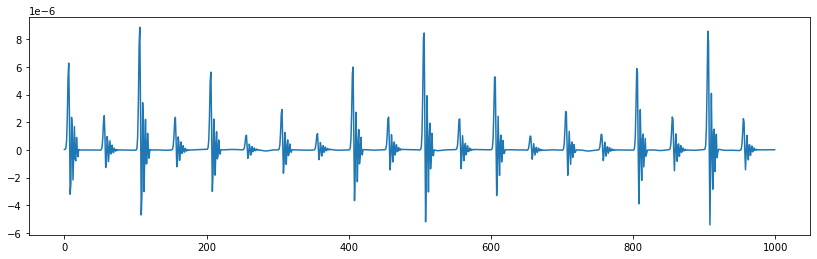

In [10]:
'''
Parameters
    ----------
    duration : int
        Desired recording length in seconds.
    sampling_rate : int
        The desired sampling rate (in Hz, i.e., samples/second).
    length : int
        The desired length of the signal (in samples).
    noise : float
        Noise level (amplitude of the laplace noise).
    heart_rate : int
        Desired simulated heart rate (in beats per minute). The default is 70. Note that for the
        scgSYN method, random fluctuations are to be expected to mimick a real heart rate. These
        fluctuations can cause some slight discrepancies between the requested heart rate and the
        empirical heart rate, especially for shorter signals.
    heart_rate_std : int
        Desired heart rate standard deviation (beats per minute).
    method : str
        The model used to generate the signal. Can be 'simple' for a simulation based on Daubechies
        wavelets that roughly approximates a single cardiac cycle. If 'scgsyn' (default), will use an
        advanced model desbribed `McSharry et al. (2003) <https://physionet.org/content/scgsyn/>`_.
    random_state : int
        Seed for the random number generator.
    Returns
    -------
    array
        Vector containing the scg signal.
'''

 #_scg_simulate_daubechies(duration=10, length=None, sampling_rate=100, heart_rate=80, respiratory_rate=10, systolic=90, diastolic=80)
sample =scg_simulate(duration=10, length=None, sampling_rate=100, noise=0.01, heart_rate=60, heart_rate_std=1, 
                          respiratory_rate=15, systolic=120, diastolic=80, method="simple", random_state=40)

#scg_sample1 = scg_simulate(duration=2, length=None, sampling_rate=100, noise=0.01, heart_rate=60, heart_rate_std=1, respiratory_rate=15, systolic=120, diastolic=60, method="simple", random_state=None
#)
print(len(sample))

#ratio=0.5
#scg_std = np.std(scg_sample)
#noise=np.random.normal(0,ratio*scg_std,200)

plt.figure(figsize=(14,4))
plt.plot(sample)
plt.show()

In [11]:
#num_points = duration * sampling_rate
    #x_space = np.linspace(0,1,num_points)
    #seg_fre = respiratory_rate / (60/duration)
    #seg_amp = max(scg) * 0.00001
    #rr_component = seg_amp * np.sin(2 * np.pi * seg_fre * x_space)
        
    #scg *= (rr_component + 2 * seg_amp)

In [12]:
#a = np.quantile(scg_sample,0.75)
#b = np.quantile(scg_sample,0.25)

#scaled_scg=(scg_sample-b)/(a-b)

#plt.figure(figsize=(8,4))
#plt.plot(scaled_scg)
#plt.show()


#### Simulate data

In [13]:
import warnings
warnings.filterwarnings("ignore")

fs = 100
duration = 10 # 3 seconds

N1=3000
N2=3000



In [14]:
## noise mean = 0.01
## height=0.3
dat1 = np.zeros((N1,fs*duration+4))

for ind in range(1500):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(50, 75)
    respiratory_rate = random.randint(10, 15)

    systolic =random.randint(90, 115)

    diastolic = random.randint(60,70) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.01, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=42)
    #print(len(data))
    dat1[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])
    
for ind in range(1500,N1):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(75, 100)
    respiratory_rate = random.randint(15, 20)

    systolic =random.randint(115, 140)

    diastolic = random.randint(70,80) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.01, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=123)
    #print(len(data))
    dat1[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

In [15]:
dat1 = np.zeros((N1,fs*duration+4))

for ind in range(N1):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = 60
    respiratory_rate = 15

    systolic = random.randint(90, 115)

    diastolic = 80

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.01, 
                        heart_rate=60, heart_rate_std=1,respiratory_rate=15, 
                        systolic=120, diastolic=80,method="simple", random_state=42
                       )
    #print(len(data))
    dat1[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])
    
for ind in range(1500,N1):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = 75
    respiratory_rate = 20

    systolic =140

    diastolic = 90

    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.01, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=123)
    #print(len(data))
    dat1[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

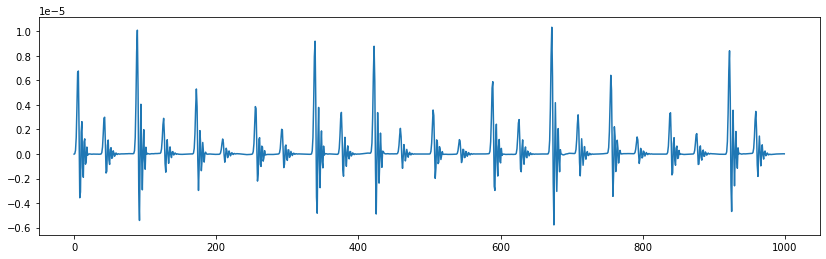

In [16]:
plt.figure(figsize=(14,4))
plt.plot(dat1[1900,:1000])
plt.show()

## Use fixed HR, RR, SBP, DBP(training/testing)

In [17]:
N1 = 10000
fs = 100
duration = 10

simulated = np.zeros((N1,fs*duration+4))

for ind in range(int(N1/2)):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(50, 100)
    respiratory_rate = random.randint(10, 20)

    systolic =random.randint(90, 140)

    diastolic = random.randint(60,80) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.1, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=40)
    #print(len(data))
    simulated[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

for ind in range(int(N1/2),N1):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(100, 150)
    respiratory_rate = random.randint(20, 30)

    systolic =random.randint(140, 180)

    diastolic = random.randint(80,100) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.1, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=40)
    #print(len(data))
    simulated[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

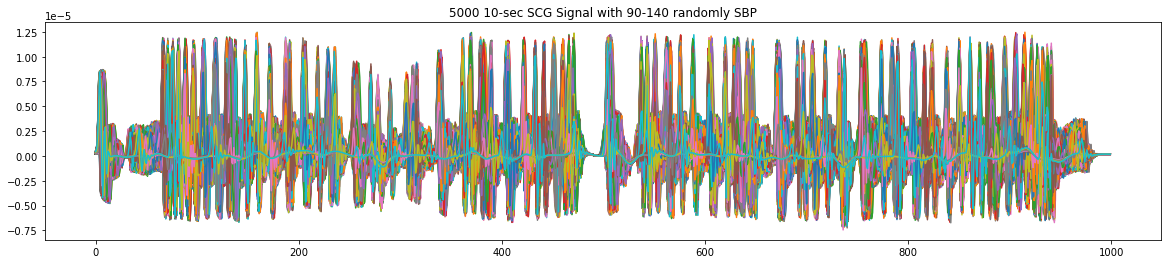

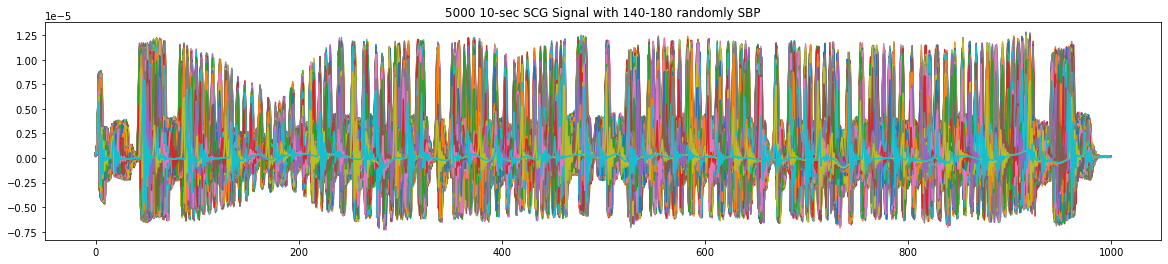

In [69]:
plt.figure(figsize=(20,4))
plt.plot(np.transpose(simulated[:5000, :1000]))
plt.title(str(int(N1/2))+" 10-sec SCG Signal with 90-140 randomly SBP")
plt.show()

plt.figure(figsize=(20,4))
plt.plot(np.transpose(simulated[5000:, :1000]))
plt.title(str(int(N1/2))+" 10-sec SCG Signal with 140-180 randomly SBP")
plt.show()

In [55]:
simulated.shape

(10000, 1004)

In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Shuffle the data
np.random.shuffle(simulated)

# Split the data into training and testing sets (70% training, 30% testing)
train_ratio = 0.7
test_ratio = 0.3

train_data, test_data = train_test_split(simulated, 
                                         test_size=3000, 
                                         train_size=7000,
                                         random_state=42)

# Convert the NumPy arrays to DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Save the DataFrames as CSV files
train_df.to_csv("/Users/racheldong/Downloads/train.csv", index=False, header=False)
test_df.to_csv("/Users/racheldong/Downloads/test.csv", index=False, header=False)

# If do not separate HR, RR, and DBP on different SBP levels

In [59]:
N1 = 10000
fs = 100
duration = 10

simulated = np.zeros((N1,fs*duration+4))

for ind in range(N1):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(50, 150)
    respiratory_rate = random.randint(10, 30)

    systolic =random.randint(90, 180)

    diastolic = random.randint(60, 100) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=89)
    #print(len(data))
    simulated[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])


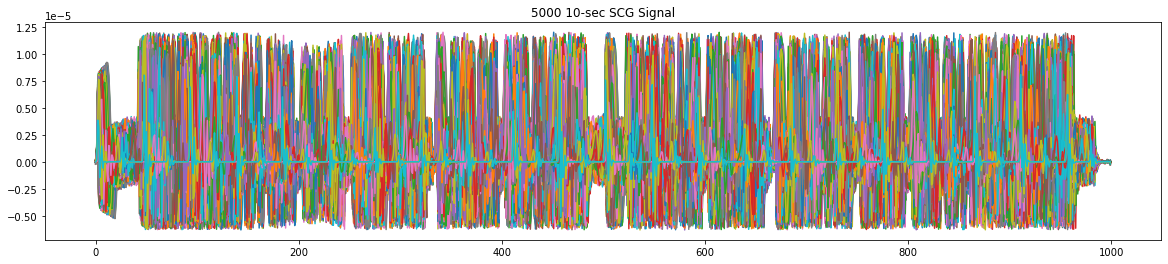

In [60]:
plt.figure(figsize=(20,4))
plt.plot(np.transpose(simulated[:5000, :1000]))
plt.title(str(int(N1/2))+" 10-sec SCG Signal")
plt.show()


In [61]:
simulated.shape

(10000, 1004)

In [62]:
# Shuffle the data
np.random.shuffle(simulated)

train_data, test_data = train_test_split(simulated, 
                                         test_size=3000, 
                                         train_size=7000,
                                         random_state=42)

# Convert the NumPy arrays to DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Save the DataFrames as CSV files
train_df.to_csv("/Users/racheldong/Downloads/train_random.csv", index=False, header=False)
test_df.to_csv("/Users/racheldong/Downloads/test_random.csv", index=False, header=False)

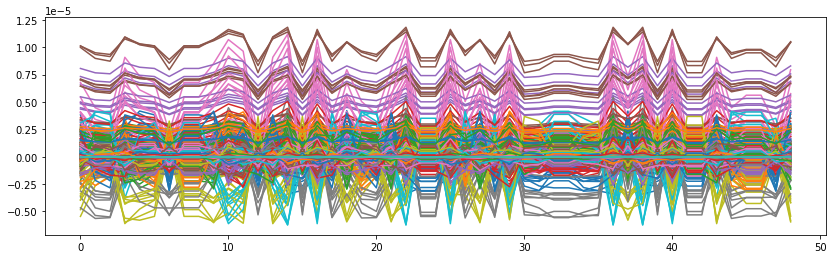

In [63]:
N2 = 3000
fs = 100
duration = 10

test = np.zeros((N1,fs*duration+4))

for ind in range(int(N2/2)):
    #noise=np.random.laplace(0.01,0.1,1)
    data = scg_simulate(duration = duration, sampling_rate = fs, noise = 0.01, 
                        heart_rate = 60, heart_rate_std=1, 
                        respiratory_rate = 15, 
                        systolic = 90, 
                        diastolic = 80, 
                        method = "simple", random_state = 56
                       )
    #print(len(data))
    test[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])
    
for ind in range(int(N2/2),N1):
    #noise=np.random.laplace(0.01,0.1,1)
    data = scg_simulate(duration = duration, sampling_rate = fs, noise = 0.01, 
                        heart_rate = 120, heart_rate_std = 1,
                        respiratory_rate = 28, 
                        systolic = 140, 
                        diastolic = 100,
                        method = "simple", random_state = 78)
    #print(len(data))
    test[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

plt.figure(figsize=(14,4))
plt.plot(test[1:50,:1000])
plt.show()

# Bingnan's Setting

In [23]:
true_lable_test_130_160 = [random.randint(130, 160) for _ in range(7000)]
true_lable_test_90_110 = [random.randint(90, 110) for _ in range(7000)]
SBP_test_130_160 = []

for i in range(len(true_lable_test_130_160)):
    temp_scg = scg_simulate(duration=2, length = 200, 
                            sampling_rate = 100,
                            noise = 0,
                            heart_rate = 60,
                            heart_rate_std = 0,
                            respiratory_rate = 15, 
                            systolic = true_lable_test_130_160[i], 
                            diastolic = 80, 
                            method = "simple", random_state = None
                           )
    SBP_test_130_160.append(temp_scg)

#plt.figure(figsize=(14,4))
#plt.plot(SBP_test_130_160[:,:1000])
#plt.show()

In [24]:
true_lable_test_130_160

[133,
 149,
 149,
 158,
 143,
 138,
 139,
 152,
 157,
 153,
 138,
 151,
 158,
 142,
 148,
 136,
 160,
 156,
 157,
 155,
 150,
 132,
 134,
 157,
 130,
 144,
 135,
 137,
 134,
 130,
 152,
 138,
 136,
 150,
 132,
 132,
 143,
 139,
 149,
 137,
 143,
 130,
 151,
 153,
 149,
 150,
 143,
 131,
 135,
 149,
 134,
 131,
 132,
 137,
 138,
 148,
 151,
 157,
 140,
 144,
 145,
 151,
 137,
 137,
 146,
 141,
 150,
 153,
 149,
 149,
 141,
 141,
 157,
 136,
 159,
 137,
 133,
 134,
 155,
 143,
 137,
 155,
 155,
 135,
 143,
 157,
 148,
 144,
 151,
 160,
 148,
 150,
 160,
 139,
 157,
 148,
 138,
 148,
 143,
 133,
 152,
 138,
 156,
 131,
 150,
 151,
 135,
 152,
 139,
 130,
 150,
 153,
 146,
 160,
 134,
 157,
 139,
 148,
 147,
 156,
 136,
 143,
 137,
 145,
 159,
 134,
 151,
 148,
 138,
 143,
 138,
 132,
 142,
 147,
 142,
 159,
 153,
 136,
 138,
 158,
 152,
 136,
 153,
 153,
 133,
 135,
 144,
 135,
 142,
 158,
 159,
 133,
 137,
 143,
 146,
 153,
 141,
 155,
 157,
 150,
 131,
 136,
 143,
 146,
 149,
 133,
 159

In [ ]:
results_table_train = pd.DataFrame({'train_true':true_lable_test_130_160, 
                                    'train_predicted':Predictions_train[:,0]},
                                   columns = ['train_true','train_predicted'])

In [41]:
true_label = pd.DataFrame({'true':true_lable_test_130_160})
true_label
true_lable_test_130_160_sorted = true_label.sort_values('true')
true_lable_test_130_160_sorted = true_lable_test_130_160_sorted.reset_index(drop = True)
true_lable_test_130_160_sorted

,true
0,130
1,130
2,130
3,130
4,130
...,...
6995,160
6996,160
6997,160
6998,160


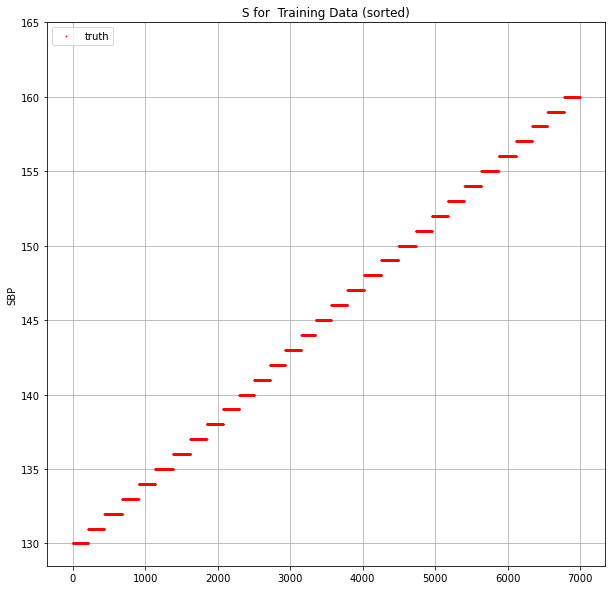

In [42]:
# sorted
plt.figure(figsize=(10,10))
plt.title('S for  Training Data (sorted)')
plt.plot(true_lable_test_130_160_sorted,'ro',label='truth',markersize=0.8)
plt.ylim(top=165) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.legend(loc="upper left")
plt.grid()

# If set noise = 0, SBP = 90, 100, 110, 120, 130, 140, 150, 160, then the true signal plot should be:

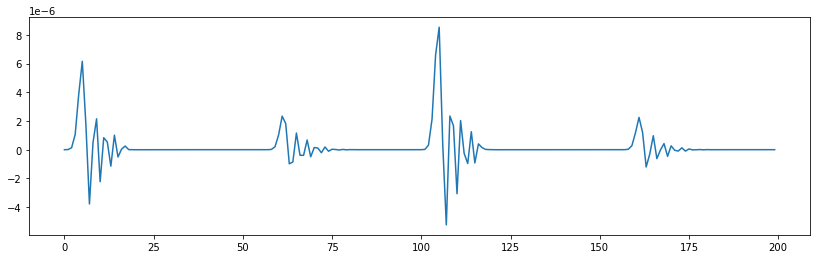

In [97]:
true_signal_130 = scg_simulate(duration=2, length = 200, 
                                sampling_rate = 100,
                                noise = 0,
                                heart_rate = 60,
                                heart_rate_std = 0,
                                respiratory_rate = 15, 
                                systolic = 130, 
                                diastolic = 80, 
                                method = "simple", random_state = None
                                )

true_signal_100 = scg_simulate(duration=2, length = 200, 
                                sampling_rate = 100,
                                noise = 0,
                                heart_rate = 60,
                                heart_rate_std = 0,
                                respiratory_rate = 15, 
                                systolic = 100, 
                                diastolic = 80, 
                                method = "simple", random_state = None
                                )

true_signal_110 = scg_simulate(duration=2, length = 200, 
                                sampling_rate = 100,
                                noise = 0,
                                heart_rate = 60,
                                heart_rate_std = 0,
                                respiratory_rate = 15, 
                                systolic = 110, 
                                diastolic = 80, 
                                method = "simple", random_state = None
                                )

true_signal_120 = scg_simulate(duration=2, length = 200, 
                                sampling_rate = 100,
                                noise = 0,
                                heart_rate = 60,
                                heart_rate_std = 0,
                                respiratory_rate = 15, 
                                systolic = 120, 
                                diastolic = 80, 
                                method = "simple", random_state = None
                                )

true_signal_115 = scg_simulate(duration=2, length = 200, 
                                sampling_rate = 100,
                                noise = 0,
                                heart_rate = 60,
                                heart_rate_std = 0,
                                respiratory_rate = 15, 
                                systolic = 115, 
                                diastolic = 80, 
                                method = "simple", random_state = 42
                                )
pd.DataFrame(true_signal_115).to_csv('true_singal_115.csv', index=False)
plt.figure(figsize=(14,4))
plt.plot(true_signal_90[:1000])
plt.show()

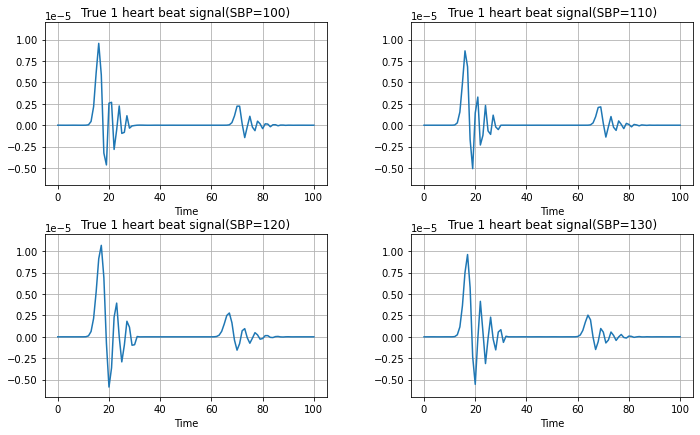

In [105]:
plt.figure()
## unsorted

plt.subplot(221)
plt.title('True 1 heart beat signal(SBP=100)')
plt.plot(true_signal_100[89:190])
plt.xlabel("Time")
plt.ylim(top=12*(1e-6), bottom = -7*(1e-6))
plt.grid()

# sorted
plt.subplot(222)
plt.title('True 1 heart beat signal(SBP=110)')
plt.plot(true_signal_110[89:190])
plt.xlabel("Time")
plt.ylim(top=12*(1e-6), bottom = -7*(1e-6))
plt.grid()

plt.subplot(223)
plt.title('True 1 heart beat signal(SBP=120)')
plt.plot(true_signal_120[89:190])
plt.xlabel("Time")
plt.ylim(top=12*(1e-6), bottom = -7*(1e-6))
plt.grid()

plt.subplot(224)
plt.title('True 1 heart beat signal(SBP=130)')
plt.plot(true_signal_130[89:190])
plt.xlabel("Time")
plt.ylim(top=12*(1e-6), bottom = -7*(1e-6))
plt.grid()

plt.subplots_adjust(top=1.6, bottom=0.30, left=0.10, right=1.60, hspace=0.30,
                    wspace=0.30)
plt.show()

# Compare fitted signal with true signal(Col mean)

In [106]:
df = pd.read_csv('/Users/racheldong/Desktop/Re_Ke/BedDot/means.csv')
df.head()
df = df.values

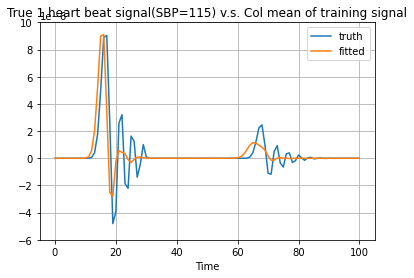

In [107]:
plt.figure()
plt.title('True 1 heart beat signal(SBP=115) v.s. Col mean of training signal')
plt.plot(true_signal_115[89:190],label='truth')
plt.plot(df,label='fitted')
plt.ylim(top=10*(1e-6), bottom = -6*(1e-6))
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.grid()

# Some non-parametric methods(Kernel Smooth)

In [123]:
spline = pd.read_csv('/Users/racheldong/Downloads/spline.csv')
spline = spline.values

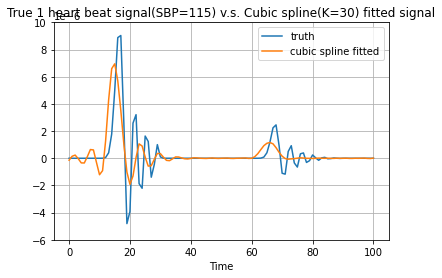

In [124]:
plt.figure()
plt.title('True 1 heart beat signal(SBP=115) v.s. Cubic spline(K=30) fitted signal')
plt.plot(true_signal_115[89:190],label='truth')
plt.plot(spline,label='cubic spline fitted')
plt.ylim(top=10*(1e-6), bottom = -6*(1e-6))
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.grid()

# fix SBP level and change HR, RR, DBP

In [125]:
true_lable_test_160 = [160 for _ in range(7000)]
true_lable_test_110 = [110 for _ in range(7000)]
SBP_test_160 = []

for i in range(len(true_lable_test_160)):
    heart_rate = random.randint(50, 150)
    respiratory_rate = random.randint(10, 30)
    diastolic = random.randint(60, 100) #+ systolic
    temp_scg = scg_simulate(duration=2, length = 200, 
                            sampling_rate = 100,
                            noise = 0.1,
                            heart_rate = heart_rate,
                            heart_rate_std = 1,
                            respiratory_rate = respiratory_rate, 
                            systolic = 160, 
                            diastolic = diastolic, 
                            method = "simple", random_state = 42
                           )
    SBP_test_160.append(temp_scg)


In [126]:
#### true signal
true_signal_160 = scg_simulate(duration=2, length = 200, 
                                sampling_rate = 100,
                                noise = 0,
                                heart_rate = 80,
                                heart_rate_std = 0,
                                respiratory_rate = 20, 
                                systolic = 160, 
                                diastolic = 80, 
                                method = "simple", random_state = 42
                                )

In [127]:
## save true signal
pd.DataFrame(true_signal_160).to_csv('true_singal_160.csv', index=False)

## save simulated signals
pd.DataFrame(SBP_test_160).to_csv('df_train_SBP_singal_160.csv', index=False)


In [31]:
dat2 = np.zeros((N2,fs*duration+4))

for ind in range(N2):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = 100
    respiratory_rate = 25

    systolic = 160
    diastolic = 95 #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.01, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=40)
    #print(len(data))
    dat2[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])
for ind in range(1500,N2):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = 125
    respiratory_rate = 30

    systolic =180

    diastolic = 100
       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.01, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=41)
    #print(len(data))
    dat2[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

In [23]:
## noise mean = 0.01
## height=0.3
dat2 = np.zeros((N2,fs*duration+4))

for ind in range(N2):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(100, 125)
    respiratory_rate = random.randint(20, 25)

    systolic =random.randint(141, 160)

    diastolic = random.randint(80,90) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.01, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=40)
    #print(len(data))
    dat2[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])
for ind in range(1500,N2):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(125, 150)
    respiratory_rate = random.randint(25, 30)

    systolic =random.randint(161, 180)

    diastolic = random.randint(90,100) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.01, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=40)
    #print(len(data))
    dat2[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

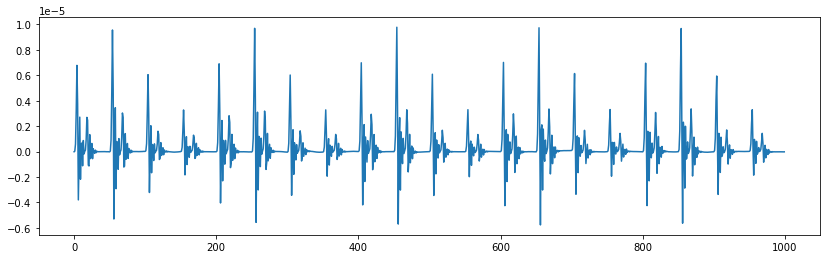

In [34]:
plt.figure(figsize=(14,4))
plt.plot(dat2[1600,:1000])
plt.show()

In [35]:
file_path = '/Users/racheldong/Desktop/Re_Ke/Tutorial/kNN/lower.csv'
np.savetxt(file_path, dat1, delimiter=',')
file_path = '/Users/racheldong/Desktop/Re_Ke/Tutorial/kNN/higher.csv'
np.savetxt(file_path, dat2, delimiter=',')

In [46]:
dat = np.zeros((N2*5,fs*duration+4))

for ind in range(N2*5):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(100, 150)
    respiratory_rate = random.randint(10, 30)

    systolic =random.randint(100, 160)

    diastolic = random.randint(60, 99) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0.01, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=42)
    #print(len(data))
    dat[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

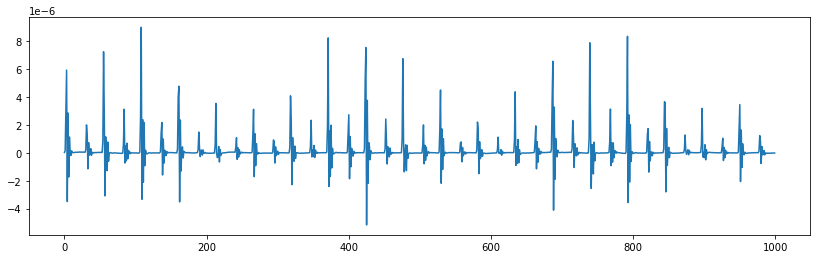

In [47]:
plt.figure(figsize=(14,4))
plt.plot(dat[1600,:1000])
plt.show()

In [48]:
file_path = '/Users/racheldong/Desktop/Re_Ke/Tutorial/kNN/total_large.csv'
np.savetxt(file_path, dat, delimiter=',')

In [16]:
max(dat1[:,-2])

150.0

In [877]:
## noise mean = 0.1
## height = 0.3
## distance=200-s
dat2 = np.zeros((N2,fs*duration+4))

for ind in range(N2):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(50, 150)
    respiratory_rate = random.randint(10, 30)

    systolic = random.randint(120, 180)
    diastolic = random.randint(60,100) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0, 
                        heart_rate=heart_rate, respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic)
    #print(len(data))
    dat2[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

In [878]:
min(dat2[:,-4])

50.0

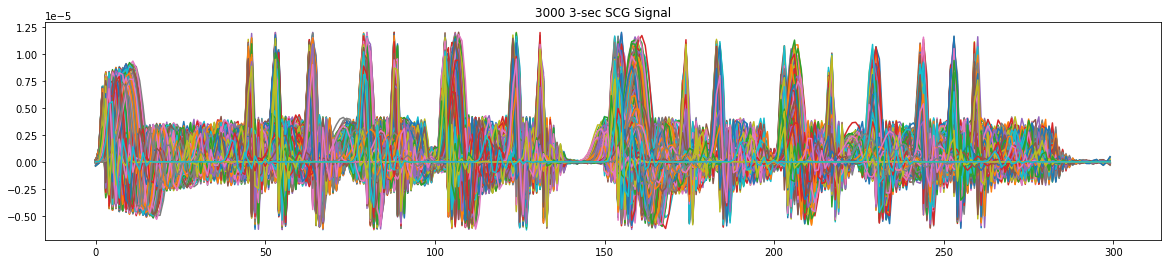

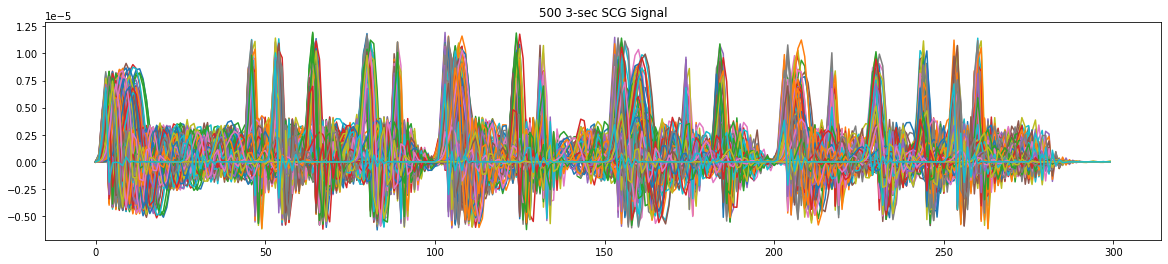

In [553]:
plt.figure(figsize=(20,4))
plt.plot(np.transpose(dat1[:,:duration*fs]))
plt.title(str(N1)+" 3-sec SCG Signal")
plt.show()

plt.figure(figsize=(20,4))
plt.plot(np.transpose(dat2[:,:duration*fs]))
plt.title(str(N2)+" 3-sec SCG Signal")
plt.show()


In [207]:
#pd.DataFrame(simulated_data).to_csv("/Users/danluo/Desktop/Signal/scg00.csv",index=False)

In [879]:
train = dat1
test = dat2


In [555]:
X_train = train[:,:300]
y_train = train[:,302]

X_test = test[:,:300]
y_test = test[:,302]


## standardize X
scaler1 = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler1.transform(X_train)

scaler2 = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler1.transform(X_test)

sample_size_train = X_train_scaled.shape[0]
sample_size_test = X_test_scaled.shape[0]
print(sample_size_train)

time_steps_train = X_train_scaled.shape[1]
time_steps_test = X_test_scaled.shape[1]
print(time_steps_train)

input_dimension = 1



## reshape the dataset
X_train_reshape = X_train_scaled.reshape(sample_size_train, time_steps_train, input_dimension)
X_test_reshape = X_test_scaled.reshape(sample_size_test, time_steps_test, input_dimension)

X_train_reshape.shape, X_test_reshape.shape

3000
300


((3000, 300, 1), (500, 300, 1))

#### 1. TCN.

In [556]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras import layers
from keras import models
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf

In [558]:
class network(object):
    
    def __init__(self, lr):
        self.lr = lr
    
    def Res_block(self, X, n_filters, strides, dilation_rate):
        x = layers.Conv1D(filters=n_filters, kernel_size=3, strides=strides, padding='causal', kernel_initializer= 'he_normal', dilation_rate = dilation_rate)(X)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x) 
        x = layers.Dropout(0.1)(x)
        x = layers.Conv1D(filters=n_filters, kernel_size=3, strides=1, padding='causal', kernel_initializer= 'he_normal', dilation_rate = dilation_rate)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x) 
        x = layers.Dropout(0.1)(x)
        input_x = layers.Conv1D(filters=n_filters, kernel_size=1, strides=strides, padding='same', kernel_initializer= 'he_normal')(X)
        x = layers.add([x, input_x])
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.1)(x)
        return x
    
    def attention_modual(self, x):
        attention = layers.Dense(units=1)(x)
        attention = layers.Flatten()(attention)
        attention = layers.Activation('softmax')(attention)
        attention = layers.Reshape((-1,1))(attention)
        x = layers.multiply([x, attention])
        return x
    
    def forward(self, X):
        self.X = X
        model_input1 = layers.Input(shape=(self.X.shape[1], 
                                          self.X.shape[2]))
        
        x = self.Res_block(model_input1, 16, 1, 1)
        x = self.Res_block(x, 32, 1, 2)
        x = self.Res_block(x, 64, 1, 4)
        x = self.Res_block(x, 128, 1, 8)
        x = self.Res_block(x, 256, 1, 16)
        x = layers.Flatten()(x)
#        x = layers.GlobalAveragePooling1D()(x)

        model_output = layers.Dense(units=1)(x)
        model = models.Model(model_input1 ,model_output)
        
        # compile model
        # optimizer = Adam(learning_rate=self.lr)
        optimizer = Adam(lr=self.lr)

        model.compile(loss = 'mse',#reweight_mse,
              optimizer=optimizer,
              metrics=['mae'])
        model.summary()
        return model
    


In [559]:
#training
print('=====================')
print('training......') 
model = network(lr = 0.001).forward(X_train_reshape)


training......
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_75 (Conv1D)              (None, 300, 16)      64          input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 300, 16)      64          conv1d_75[0][0]                  
__________________________________________________________________________________________________
activation_75 (Activation)      (None, 300, 16)      0           batch_normalization_75[0][0]     
_______________________________________________________________________

In [560]:
history=model.fit(X_train_reshape, y_train, batch_size = 16, epochs=100,verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/100
169/169 [==============================] - 63s 374ms/step - loss: 419.5049 - mae: 12.4105 - val_loss: 637.9295 - val_mae: 24.8063
Epoch 2/100
169/169 [==============================] - 70s 416ms/step - loss: 23.5177 - mae: 3.8497 - val_loss: 40.4648 - val_mae: 5.0353
Epoch 3/100
169/169 [==============================] - 66s 393ms/step - loss: 12.0524 - mae: 2.7832 - val_loss: 37.4875 - val_mae: 4.8421
Epoch 4/100
169/169 [==============================] - 66s 390ms/step - loss: 10.6235 - mae: 2.6113 - val_loss: 27.0420 - val_mae: 4.1747
Epoch 5/100
169/169 [==============================] - 65s 383ms/step - loss: 10.2753 - mae: 2.5494 - val_loss: 70.7947 - val_mae: 7.0505
Epoch 6/100
169/169 [==============================] - 64s 376ms/step - loss: 8.8105 - mae: 2.3564 - val_loss: 53.2971 - val_mae: 5.9512
Epoch 7/100
169/169 [==============================] - 63s 371ms/step - loss: 8.3429 - mae: 2.2847 - val_loss: 30.8928 - val_mae: 4.5031
Epoch 8/100
169/169 [===========

In [561]:
Predictions_train=model.predict(X_train_reshape)
Predictions_test=model.predict(X_test_reshape)

results_table_train = pd.DataFrame({'train_true':y_train, 'train_predicted':Predictions_train[:,0]},
                                   columns = ['train_true','train_predicted'])
results_table_test = pd.DataFrame({'test_true':y_test, 'test_predicted':Predictions_test[:,0]}, 
                             columns = ['test_true','test_predicted'])

results_table_train_sorted = results_table_train.sort_values('train_true')
results_table_train_sorted = results_table_train_sorted.reset_index(drop = True)

results_table_test_sorted = results_table_test.sort_values('test_true')
results_table_test_sorted = results_table_test_sorted.reset_index(drop = True)
print(results_table_test_sorted)

     test_true  test_predicted
0        120.0      117.477715
1        120.0      118.782074
2        120.0      117.663345
3        120.0      117.666122
4        120.0      117.904526
..         ...             ...
495      180.0      124.417465
496      180.0      131.457840
497      180.0      125.413315
498      180.0      123.535202
499      180.0      128.473709

[500 rows x 2 columns]


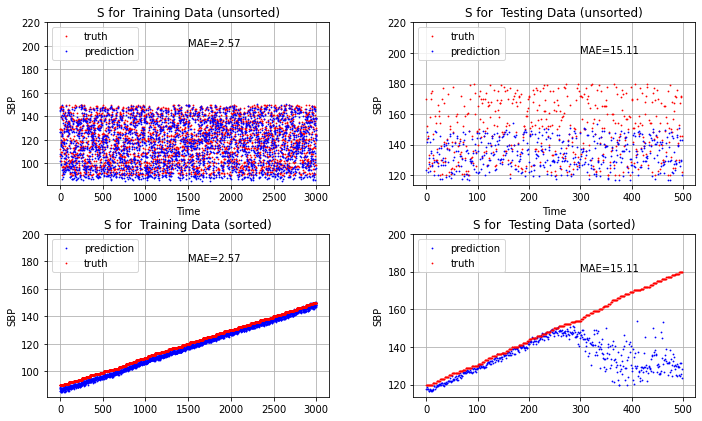

In [562]:
# MAE for training data
MAE_trainS=sm.mean_absolute_error(results_table_train.train_true,results_table_train.train_predicted)

# MAE for test data
MAE_testS=sm.mean_absolute_error(results_table_test.test_true,results_table_test.test_predicted)


plt.figure()
## unsorted
plt.subplot(221)
plt.title('S for  Training Data (unsorted)')
plt.plot(results_table_train.train_true,'ro',label='truth',markersize=0.8)
plt.plot(results_table_train.train_predicted,'bo',label='prediction',markersize=0.8)
plt.ylim(top=220) 
plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(1500,200,"MAE=" +str(round(MAE_trainS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplot(222)
plt.title('S for  Testing Data (unsorted)')
plt.plot(results_table_test.test_true,'ro',label='truth',markersize=0.8)
plt.plot(results_table_test.test_predicted,'bo',label='prediction',markersize=0.8)
plt.ylim(top=220) 
plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(300,200,"MAE=" +str(round(MAE_testS,2)))
plt.legend(loc="upper left")
plt.grid()

# sorted
plt.subplot(223)
plt.title('S for  Training Data (sorted)')
plt.plot(results_table_train_sorted.train_predicted,'bo',label='prediction',markersize=0.8)
plt.plot(results_table_train_sorted.train_true,'ro',label='truth',markersize=0.8)
plt.ylim(top=200) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(1500,180,"MAE=" +str(round(MAE_trainS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplot(224)
plt.title('S for  Testing Data (sorted)')
plt.plot(results_table_test_sorted.test_predicted,'bo',label='prediction',markersize=0.8)
plt.plot(results_table_test_sorted.test_true,'ro',label='truth',markersize=0.8)
plt.ylim(top=200) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(300,180,"MAE=" +str(round(MAE_testS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplots_adjust(top=1.6, bottom=0.30, left=0.10, right=1.60, hspace=0.30,
                    wspace=0.30)
plt.show()

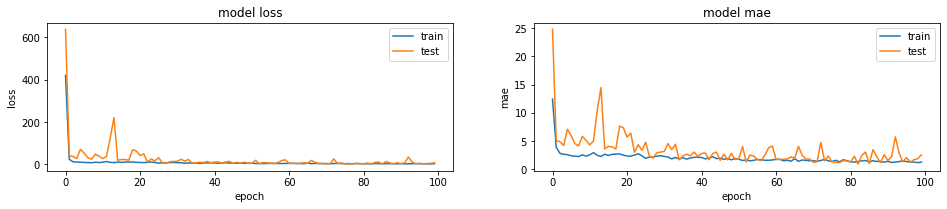

In [563]:
## summarize history for loss
plt.figure(figsize=(16, 6)) 

plt.subplot(221)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(222)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### 2. LVET.

In [881]:
#### calculate LVET

num_hb_train = (duration*train[:,-4]/60).astype(int)
num_hb_test = (duration*test[:,-4]/60).astype(int)

# the index of first heart beat
ind_train = ((duration*fs)/num_hb_train).astype(int)
ind_test = ((duration*fs)/num_hb_test).astype(int)

# LVET for training
LVET_train = np.zeros(len(num_hb_train))

for i in range(len(num_hb_train)):
    d = ((ind_train/3).astype(int))[i]
    #print(d)
    peaks, _ = find_peaks(train[i,:ind_train[i]],distance = d)
    LVET_train[i] = peaks[1]-peaks[0]
    
# LVET for testing
LVET_test = np.zeros(len(num_hb_test))

for i in range(len(num_hb_test)):
    d = ((ind_test/3).astype(int))[i]
    #print(d)
    peaks, _ = find_peaks(test[i,:ind_test[i]],distance = d)
    LVET_test[i] = peaks[1]-peaks[0]

In [882]:
max(LVET_train)

85.0

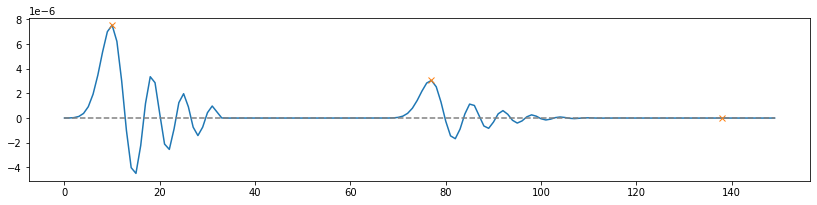

In [883]:
ll = -3
l = train[ll,:int((duration*fs)/num_hb_train[ll])]

peaks, _ = find_peaks(l,distance = ((ind_train/3).astype(int))[ll])

plt.figure(figsize=(14,3))
plt.plot(l)
plt.plot(peaks, l[peaks], "x")
plt.plot(np.zeros_like(l), "--", color="gray")
plt.show()



In [916]:
#### Linear regression


# define response variable
y_train = train[:,-2]
y_test = test[:,-2]

# define predictor variables (ln(LVET), HR)
X_train = np.transpose(np.array([np.log(LVET_train),train[:,-4],np.log(LVET_train)*train[:,-4]]))
X_test = np.transpose(np.array([np.log(LVET_test),test[:,-4],np.log(LVET_test)*test[:,-4]]))

#add constant to predictor variables
X_train = sma.add_constant(X_train)
X_test = sma.add_constant(X_test)
    
#fit linear regression model
model = sma.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     1589.
Date:                Thu, 13 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:56:22   Log-Likelihood:                -11419.
No. Observations:                3000   AIC:                         2.285e+04
Df Residuals:                    2996   BIC:                         2.287e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        402.6108      7.735     52.049      0.0

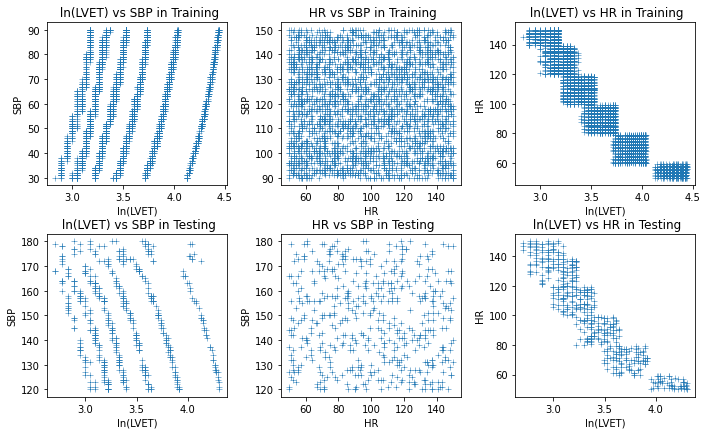

In [920]:
plt.figure()
plt.subplot(231)
plt.scatter(np.log(LVET_train), 180-y_train, marker="+",linewidths=0.5)
plt.xlabel("ln(LVET)")
plt.ylabel("SBP")
plt.title(" ln(LVET) vs SBP in Training")


plt.subplot(232)
plt.scatter(train[:,-4], y_train, marker="+",linewidths=0.5)
plt.xlabel("HR")
plt.ylabel("SBP")
plt.title(" HR vs SBP in Training")

plt.subplot(233)
plt.scatter(np.log(LVET_train),train[:,-4], marker="+",linewidths=0.5)
plt.xlabel("ln(LVET)")
plt.ylabel("HR")
plt.title(" ln(LVET) vs HR in Training")

plt.subplot(234)
plt.scatter(np.log(LVET_test), y_test, marker="+",linewidths=0.5)
plt.xlabel("ln(LVET)")
plt.ylabel("SBP")
plt.title(" ln(LVET) vs SBP in Testing")


plt.subplot(235)
plt.scatter(test[:,-4], y_test, marker="+",linewidths=0.5)
plt.xlabel("HR")
plt.ylabel("SBP")
plt.title(" HR vs SBP in Testing")

plt.subplot(236)
plt.scatter(np.log(LVET_test),test[:,-4], marker="+",linewidths=0.5)
plt.xlabel("ln(LVET)")
plt.ylabel("HR")
plt.title(" ln(LVET) vs HR in Testing")

plt.subplots_adjust(top=1.6, bottom=0.30, left=0.10, right=1.60, hspace=0.30,
                    wspace=0.30)
plt.show()

In [892]:
xlim

(2.833213344056216, 4.442651256490317)

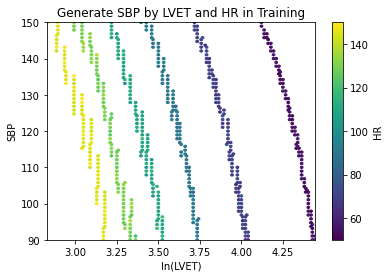

In [922]:

fig, ax0 = plt.subplots()

hb = ax0.hexbin(np.log(LVET_train), y_train, gridsize=100,C=train[:,-4])#, cmap='inferno')
ax0.set(xlim=(np.log(LVET_train).min(),np.log(LVET_train).max()), ylim=(y_train.min(),y_train.max()))
ax0.set_title("Generate SBP by LVET and HR in Training")
ax0.set_xlabel("ln(LVET)")
ax0.set_ylabel("SBP")
cb = fig.colorbar(hb, ax=ax0, label='HR')



plt.show()


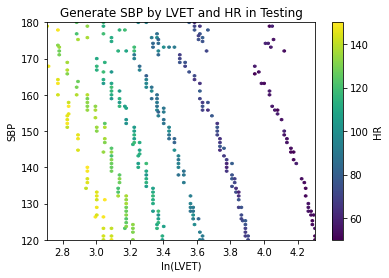

In [911]:
fig, ax1 = plt.subplots()
hb = ax1.hexbin(np.log(LVET_test), y_test, gridsize=100,C=test[:,-4])#, cmap='inferno')
ax1.set(xlim=(np.log(LVET_test).min(),np.log(LVET_test).max()), ylim=(y_test.min(),y_test.max()))
ax1.set_title("Generate SBP by LVET and HR in Testing")
ax1.set_xlabel("ln(LVET)")
ax1.set_ylabel("SBP")
cb = fig.colorbar(hb, ax=ax1, label='HR')

plt.show()

In [917]:
Predictions_train=model.predict(X_train)
Predictions_test=model.predict(X_test)

results_table_train = pd.DataFrame({'train_true':y_train, 'train_predicted':Predictions_train},
                                   columns = ['train_true','train_predicted'])
results_table_test = pd.DataFrame({'test_true':y_test, 'test_predicted':Predictions_test}, 
                             columns = ['test_true','test_predicted'])

results_table_train_sorted = results_table_train.sort_values('train_true')
results_table_train_sorted = results_table_train_sorted.reset_index(drop = True)

results_table_test_sorted = results_table_test.sort_values('test_true')
results_table_test_sorted = results_table_test_sorted.reset_index(drop = True)
print(results_table_test_sorted)

     test_true  test_predicted
0        120.0      108.714375
1        120.0      116.515083
2        120.0      116.970321
3        120.0      122.031739
4        120.0      113.343425
..         ...             ...
495      180.0      153.857823
496      180.0      148.459844
497      180.0      141.242480
498      180.0      164.225222
499      180.0      150.429556

[500 rows x 2 columns]


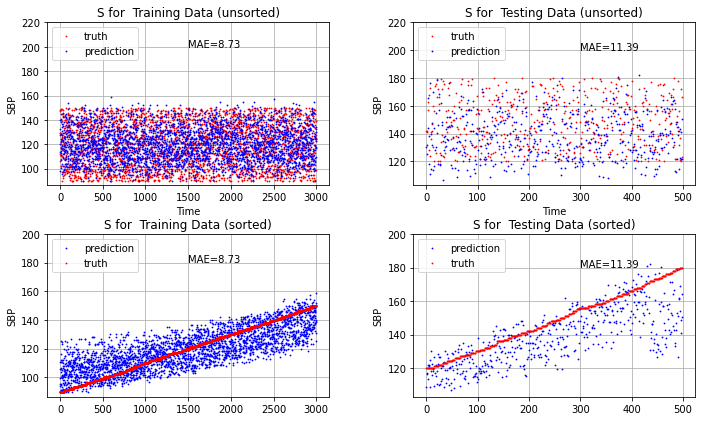

In [918]:
# MAE for training data
MAE_trainS=sm.mean_absolute_error(results_table_train.train_true,results_table_train.train_predicted)

# MAE for test data
MAE_testS=sm.mean_absolute_error(results_table_test.test_true,results_table_test.test_predicted)


plt.figure()
## unsorted
plt.subplot(221)
plt.title('S for  Training Data (unsorted)')
plt.plot(results_table_train.train_true,'ro',label='truth',markersize=0.8)
plt.plot(results_table_train.train_predicted,'bo',label='prediction',markersize=0.8)
plt.ylim(top=220) 
plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(1500,200,"MAE=" +str(round(MAE_trainS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplot(222)
plt.title('S for  Testing Data (unsorted)')
plt.plot(results_table_test.test_true,'ro',label='truth',markersize=0.8)
plt.plot(results_table_test.test_predicted,'bo',label='prediction',markersize=0.8)
plt.ylim(top=220) 
plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(300,200,"MAE=" +str(round(MAE_testS,2)))
plt.legend(loc="upper left")
plt.grid()

# sorted
plt.subplot(223)
plt.title('S for  Training Data (sorted)')
plt.plot(results_table_train_sorted.train_predicted,'bo',label='prediction',markersize=0.8)
plt.plot(results_table_train_sorted.train_true,'ro',label='truth',markersize=0.8)
plt.ylim(top=200) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(1500,180,"MAE=" +str(round(MAE_trainS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplot(224)
plt.title('S for  Testing Data (sorted)')
plt.plot(results_table_test_sorted.test_predicted,'bo',label='prediction',markersize=0.8)
plt.plot(results_table_test_sorted.test_true,'ro',label='truth',markersize=0.8)
plt.ylim(top=200) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(300,180,"MAE=" +str(round(MAE_testS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplots_adjust(top=1.6, bottom=0.30, left=0.10, right=1.60, hspace=0.30,
                    wspace=0.30)
plt.show()

##### distance vs LVET.

In [11]:
### fixed HR to simulate SCG signal
fs = 100
duration=3
N3 = 3000
N4 = 500
dat3 = np.zeros((N3,fs*duration+4))

for ind in range(N3):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = 60#random.randint(50, 150)
    respiratory_rate = random.randint(10, 30)

    systolic =random.randint(90, 140)

    diastolic = random.randint(60,100) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=40)
    #print(len(data))
    dat3[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])
    
    
    
    
dat4 = np.zeros((N4,fs*duration+4))

for ind in range(N4):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = 60#random.randint(50, 150)
    respiratory_rate = random.randint(10, 30)

    systolic = random.randint(120, 160)
    diastolic = random.randint(60,100) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0, 
                        heart_rate=heart_rate, respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic)
    #print(len(data))
    dat4[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

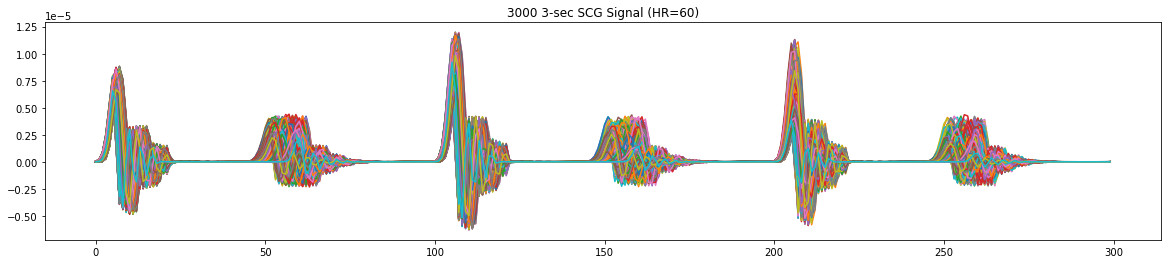

NameError: name 'dat4' is not defined

<Figure size 1440x288 with 0 Axes>

In [14]:
plt.figure(figsize=(20,4))
plt.plot(np.transpose(dat3[:,:duration*fs]))
plt.title(str(N3)+" 3-sec SCG Signal (HR=60)")
plt.show()

plt.figure(figsize=(20,4))
plt.plot(np.transpose(dat4[:,:duration*fs]))
plt.title(str(N4)+" 3-sec SCG Signal (HR=60)")
plt.show()


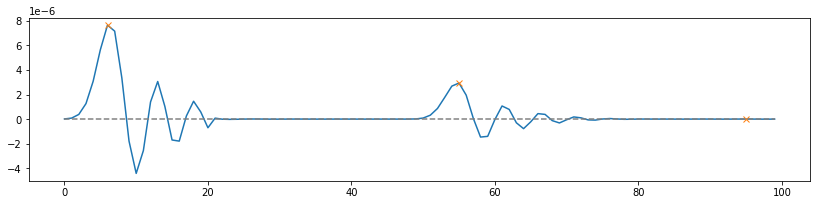

In [59]:
ll = -3
l = train[ll,:int((duration*fs)/num_hb_train[ll])]

peaks, _ = find_peaks(l,distance = ((ind_train/3).astype(int))[ll])

plt.figure(figsize=(14,3))
plt.plot(l)
plt.plot(peaks, l[peaks], "x")
plt.plot(np.zeros_like(l), "--", color="gray")
plt.show()


In [14]:
train=dat3
test=dat4

In [17]:
#### calculate LVET

num_hb_train = (duration*train[:,-4]/60).astype(int)
num_hb_test = (duration*test[:,-4]/60).astype(int)

# the index of first heart beat
ind_train = ((duration*fs)/num_hb_train).astype(int)
ind_test = ((duration*fs)/num_hb_test).astype(int)

# LVET for training
LVET_train = np.zeros(len(num_hb_train))

for i in range(len(num_hb_train)):
    d = ((ind_train/3).astype(int))[i]
    #print(d)
    peaks, _ = find_peaks(train[i,:ind_train[i]],distance = d)
    LVET_train[i] = peaks[1]-peaks[0]
    
# LVET for testing
LVET_test = np.zeros(len(num_hb_test))

for i in range(len(num_hb_test)):
    d = ((ind_test/3).astype(int))[i]
    #print(d)
    peaks, _ = find_peaks(test[i,:ind_test[i]],distance = d)
    LVET_test[i] = peaks[1]-peaks[0]
    
    
# Distance 
Distance_train = 180-train[:,-2]
Distance_test = 180-test[:,-2]

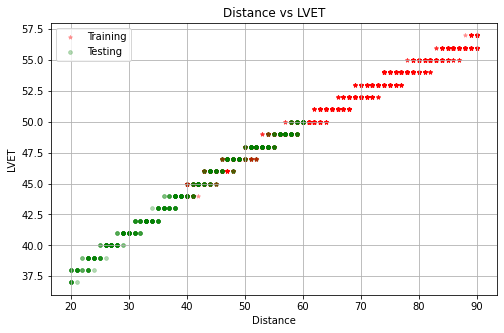

In [60]:

## Distance vs LVET
plt.figure(figsize=(8,5))
#plt.subplot(121)
plt.scatter(Distance_train,LVET_train,color='r',alpha=0.3,s=15,marker="*",label="Training")
plt.scatter(Distance_test,LVET_test, color="g",alpha=0.3,s=15,linewidths=0.6,label="Testing")
plt.xlabel("Distance")
plt.ylabel("LVET")
plt.title("Distance vs LVET")
plt.legend(loc="upper left")
plt.grid()

#plt.subplot(122)
#plt.scatter(Distance_test,LVET_test)
#plt.xlabel("Distance")
#plt.ylabel("LVET")
#plt.title("Distance vs LVET in Testing")
plt.show()

In [61]:
#### Linear regression


# define response variable
y_train = Distance_train
y_test = Distance_test

# define predictor variables (ln(LVET), HR)
X_train = np.transpose(np.array([LVET_train]))
X_test = np.transpose(np.array([LVET_test]))

#add constant to predictor variables
X_train = sma.add_constant(X_train)
X_test = sma.add_constant(X_test)
    
#fit linear regression model
model = sma.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.929e+05
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        11:05:08   Log-Likelihood:                -6022.2
No. Observations:                3000   AIC:                         1.205e+04
Df Residuals:                    2998   BIC:                         1.206e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -141.8251      0.473   -300.120      0.0

In [1084]:
from sklearn import linear_model

clf = linear_model.PoissonRegressor(alpha=0.01,max_iter=200)

X = LVET_train.reshape(3000,1)
y = Distance_train.reshape(3000,1)
clf.fit(X,y)

PoissonRegressor(alpha=0.01, max_iter=200)

In [64]:
pred_distance_train = model.predict(X_train)
pred_distance_test = model.predict(X_test)


Predictions_train=180-pred_distance_train
Predictions_test=180-pred_distance_test

results_table_train = pd.DataFrame({'train_true':train[:,-2], 'train_predicted':Predictions_train},
                                   columns = ['train_true','train_predicted'])
results_table_test = pd.DataFrame({'test_true':test[:,-2], 'test_predicted':Predictions_test}, 
                             columns = ['test_true','test_predicted'])

results_table_train_sorted = results_table_train.sort_values('train_true')
results_table_train_sorted = results_table_train_sorted.reset_index(drop = True)

results_table_test_sorted = results_table_test.sort_values('test_true')
results_table_test_sorted = results_table_test_sorted.reset_index(drop = True)
print(results_table_test_sorted)

     test_true  test_predicted
0        120.0      118.640877
1        120.0      118.640877
2        120.0      118.640877
3        120.0      118.640877
4        120.0      118.640877
..         ...             ...
495      160.0      171.468783
496      160.0      167.405098
497      160.0      167.405098
498      160.0      171.468783
499      160.0      171.468783

[500 rows x 2 columns]


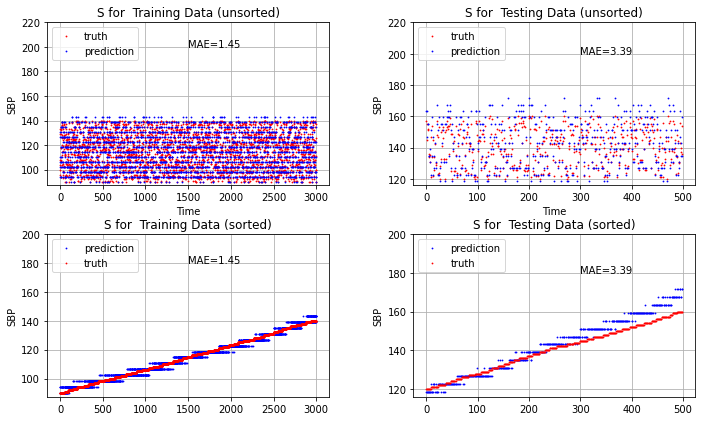

In [65]:
# MAE for training data
MAE_trainS=sm.mean_absolute_error(results_table_train.train_true,results_table_train.train_predicted)

# MAE for test data
MAE_testS=sm.mean_absolute_error(results_table_test.test_true,results_table_test.test_predicted)


plt.figure()
## unsorted
plt.subplot(221)
plt.title('S for  Training Data (unsorted)')
plt.plot(results_table_train.train_true,'ro',label='truth',markersize=0.8)
plt.plot(results_table_train.train_predicted,'bo',label='prediction',markersize=0.8)
plt.ylim(top=220) 
plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(1500,200,"MAE=" +str(round(MAE_trainS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplot(222)
plt.title('S for  Testing Data (unsorted)')
plt.plot(results_table_test.test_true,'ro',label='truth',markersize=0.8)
plt.plot(results_table_test.test_predicted,'bo',label='prediction',markersize=0.8)
plt.ylim(top=220) 
plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(300,200,"MAE=" +str(round(MAE_testS,2)))
plt.legend(loc="upper left")
plt.grid()

# sorted
plt.subplot(223)
plt.title('S for  Training Data (sorted)')
plt.plot(results_table_train_sorted.train_predicted,'bo',label='prediction',markersize=0.8)
plt.plot(results_table_train_sorted.train_true,'ro',label='truth',markersize=0.8)
plt.ylim(top=200) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(1500,180,"MAE=" +str(round(MAE_trainS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplot(224)
plt.title('S for  Testing Data (sorted)')
plt.plot(results_table_test_sorted.test_predicted,'bo',label='prediction',markersize=0.8)
plt.plot(results_table_test_sorted.test_true,'ro',label='truth',markersize=0.8)
plt.ylim(top=200) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(300,180,"MAE=" +str(round(MAE_testS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplots_adjust(top=1.6, bottom=0.30, left=0.10, right=1.60, hspace=0.30,
                    wspace=0.30)
plt.show()

In [27]:
### 3-seconds SDG signal
fs = 100
duration= 10
N = 3000
dat = np.zeros((N,fs*duration+4))

for ind in range(N):
    #noise=np.random.laplace(0.01,0.1,1)
    heart_rate = random.randint(50, 150)
    respiratory_rate = random.randint(10, 30)

    systolic =random.randint(90, 140)

    diastolic = random.randint(60,100) #+ systolic

       
    data = scg_simulate(duration=duration, sampling_rate=fs, noise=0, 
                        heart_rate=heart_rate, heart_rate_std=1,respiratory_rate=respiratory_rate, 
                        systolic=systolic, diastolic=diastolic,method="simple", random_state=40)
    #print(len(data))
    dat[ind,:] = (list(data)+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])
    
    


In [28]:
dat.shape

(3000, 1004)

In [29]:

file_path = '/Users/racheldong/Desktop/Re_Ke/simulator/simulated_dataset.csv'
np.savetxt(file_path, dat, delimiter=',')


In [31]:
column_names = [str(i) for i in range(1, duration*fs+1)] + ['heart_rate', 'respiratory_rate', 'systolic', 'diastolic']
df = pd.read_csv('/Users/racheldong/Desktop/Re_Ke/simulator/simulated_dataset.csv', 
                 header=None, 
                 names=column_names)
# df = pd.DataFrame(df)
print(df)

                 1             2             3             4         5  \
0    -9.281858e-10  5.722819e-07  5.438952e-06  4.135970e-06 -0.000004   
1     1.733409e-09  1.415292e-07  2.988386e-06  4.414962e-06 -0.000003   
2    -9.985923e-10  3.414463e-07  3.797022e-06  5.395219e-06 -0.000003   
3     1.483507e-08  4.010992e-07  2.514697e-06  6.738557e-06  0.000007   
4     9.850124e-09  3.718731e-07  4.072503e-06  6.279830e-06 -0.000004   
...            ...           ...           ...           ...       ...   
2995  1.188457e-09  2.896139e-09  3.762047e-08  2.965795e-07  0.000001   
2996 -3.032236e-08  5.925956e-08  2.937072e-06  3.824217e-06 -0.000001   
2997  3.225452e-09  2.364535e-08  1.125392e-07  3.924122e-07  0.000001   
2998  1.403685e-08  2.386586e-07  1.747295e-06  5.597123e-06  0.000008   
2999  1.200415e-08  1.903264e-07  1.117208e-06  3.638988e-06  0.000007   

                 6             7             8             9            10  \
0     2.647285e-06 -1.760946e-06 